# Object Detection with KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml), Ian Stenbit, Tirth Patel<br>
**Date created:** 2023/04/08<br>
**Last modified:** 2023/08/10<br>
**Description:** Train an object detection model with KerasCV.

KerasCV предлагает полный набор API для решения задач обнаружения объектов. Эти API-интерфейсы включают в себя методы расширения данных, специфичные для обнаружения объектов, встроенные в Keras метрики COCO, утилиты преобразования формата ограничивающих рамок, инструменты визуализации, предварительно обученные модели обнаружения объектов и все, что вам нужно для обучения ваших собственных современных моделей обнаружения объектов!

Давайте рассмотрим API обнаружения объектов в KerasCV.

In [2]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Введение в обнаружение объектов

Обнаружение объектов - это процесс идентификации, классификации и локализации объектов в пределах заданного изображения. Как правило, входными данными являются изображения, а метками - ограничивающие рамки с необязательными метками классов. Обнаружение объектов можно рассматривать как расширение классификации, однако вместо обозначения одного класса для изображения вы должны обнаружить и локализовать произвольное количество классов.

**Например:**

<img width="300" src="https://i.imgur.com/8xSEbQD.png">

Данные для приведенного выше изображения могут выглядеть примерно так:
```python
image = [height, width, 3]
bounding_boxes = {
  "classes": [0], # 0 is an arbitrary class ID representing "cat"
  "boxes": [[0.25, 0.4, .15, .1]]
   # bounding box is in "rel_xywh" format
   # so 0.25 represents the start of the bounding box 25% of
   # the way across the image.
   # The .15 represents that the width is 15% of the image width.
}
```

С появлением [*You Only Look Once*](https://arxiv.org/abs/1506.02640)
(aka YOLO), задачи по обнаружению объектов решаются с помощью глубокого обучения.
Большинство архитектур машинного обучения делают умное разбиение одной задачи по обнаружению, на множество небольших задач по классификации и множество задач по регрессии.

Если быть более точным, то происходит генерация многоякорных рамок различных форм и размеров на входном изображении и каждой рамке присваивается класс, в соответствии со смещением по x, y, ширине и высоте. Модель обучается предсказывать класс каждой рамки, в соответствии со смещениями по осям x и y, ширине, высоте для каждой рамки с предполагаемым объектом.

**Пример визуализации якорных рамок**:

<img width="400" src="https://i.imgur.com/cJIuiK9.jpg">

Обнаружение объектов технически сложная задача, но к счастью, мы можем предложить безупречный подход для получения отличного результата. Приступим!


## Обнаружение с помощью предобученной модели

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

Самый верхний уровень API в KerasCV это интерфейс обнаружения объектов: `keras_cv.models`. Этот API включает полностью предобученную модель по обнаружению объектов, такую как `keras_cv.models.YOLOV8Detector`.

Давайте начнем с построения модели YOLOV8Detector предобученной на наборе данных `pascalvoc`.

In [4]:
## в переменную pretrained_model загружается предобученная модель по обнаружению объектов YOLOV8Detector
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh" ## формат объектных рамок
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 2.32MB/s]
100%|██████████| 99.5M/99.5M [00:18<00:00, 5.62MB/s]


Заметили аргумент с названием `bounding_box_format`?

Вспоминаем, ранее описанный, формат словаря bounding boxes:

```
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

Данный аргумент описывает какой *точно* будет формат значений у ключа "boxes" в словаре, который отправится далее по конвейеру. Например, рамка в формате `xywh` в ее верхнем левом углу имеет координаты $x=100$, $y=100$, ширина 55 и высота 70, тогда значение будут выглядеть:
```
[100, 100, 55, 75]
```

что эквивалентно значению в формате `xyxy`:
```
[100, 100, 155, 175]
```

Кажется очень простым, но это критически важный момент в понимании API обнаружения объектов в KerasCV!
Каждому компоненту, вычисляющему рамки объектов, требуется аргумент `bounding_box_format`.

Подробнее о KerasCV, вы можете почитать тут: [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Так получилось, из-за того что нет единого стандарта, описывающего формат объектной рамки! В различных конвейерах, его компоненты ожидают разные форматы, таким образом, их нужно указывать явно, для того, чтобы наш код оставался читаемым, переиспользуемым и ясным.

Баг связанный с неправильным форматом объектной рамки, возможно, самый частый баг, лежащий в основе проблем обнаружения внутри конвейера - и явно указывая формат мы исключаем подобные баги (особенно если копипастим код из разных источников).

Далее, давайте загрузим изображение:

264095/264095 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


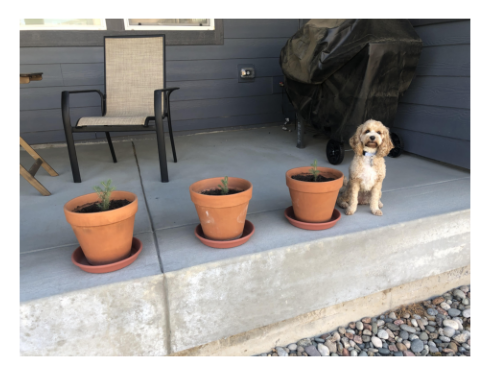

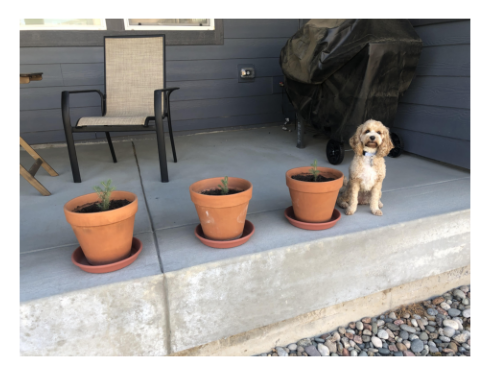

In [6]:
#URL fetch failure on https://i.imgur.com/gCNcJJI.jpg: 429 -- Unknown Error - недействительный адрес
filepath = keras.utils.get_file(origin="https://keras.io/img/guides/object_detection_keras_cv/object_detection_keras_cv_8_0.png")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

Для использования архитектуры `YOLOV8Detector` с сеткой ResNet50 в качестве основы, вам нужно изменить размеры картинки, так чтобы они были кратны 64.
Это нужно для того, чтобы быть уверенным в совместимости с количеством точек разрешения, при дальнейшем уменьшении размерностей в сверточных уровнях сети ResNet.

Если, операция изменения размера исказит входное соотношение, модель будет более слабой. Для предобученной модели `yolo_v8_m_pascalvoc`, те настройки которые мы используем, отразятся на конечной метрике `MeanAveragePrecision`, на примере набора данных `pascalvoc/2012` расчетный коэффициент упадет до `0.15` с `0.38`, при использовании встроенных операций изменения размеров.

Вдобавок, если для сохранения пропорций применить обрезку, как это делается в задачах по классификации, то ваша модель может вовсе потерять часть рамок. И если, требуется сохранить соотношения сторон, то мы рекомендуем использовать padding (дополнение пустотой), чтобы дополнить короткую сторону пустотой до более длинной при изменении разрешения.

С помощью KerasCV изменения размеров изображения делается легко: необходимо задать аргумент `pad_to_aspect_ratio=True` в слое `keras_cv.layers.Resizing`.

Это можно сделать одной строчкой кода:

In [7]:
# предпроцессный слой служит для изменения размера
inference_resizing = keras_cv.layers.Resizing(
    640,  # желаемая высота картинки в пикселях
    640,  # желаемая ширина картинки в пикселях
    pad_to_aspect_ratio=True,  # прибавить пустоту для соблюдения пропорций
    bounding_box_format="xywh"  # формат объектных рамок
)

Передадим дальше по конвейеру:

In [8]:
# методу inference_resizing() передаем картинку в виде тензора, обратно получаем обработанный тензор
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()` поддерживает параметр `class_mapping` для определения классов объектных рамок.

Давайте отобразим наши классы.

In [9]:
class_ids = [  # ID классов
    "Aeroplane", # самолет
    "Bicycle", # велосипед
    "Bird", # птица
    "Boat", # лодка
    "Bottle", # бутылка
    "Bus", # автобус
    "Car", # машина
    "Cat", # кошка
    "Chair", # стул
    "Cow", # корова
    "Dining Table", # столик
    "Dog", # собака
    "Horse", # лошадь
    "Motorbike", # мотоцикл
    "Person", # человек
    "Potted Plant", # цветочный горшок
    "Sheep", # овца
    "Sofa", # диван
    "Train", # поезд
    "Tvmonitor", # ТВ-экран
    "Total", # все остальное
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))  # помещаем все классы в словарь

Как и в любой другой модели, в нашей `keras.Model` мы можем предсказать объектные рамки с помощью интерфейса `model.predict()`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


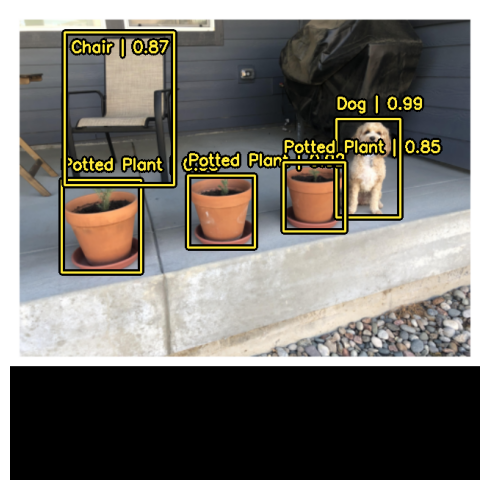

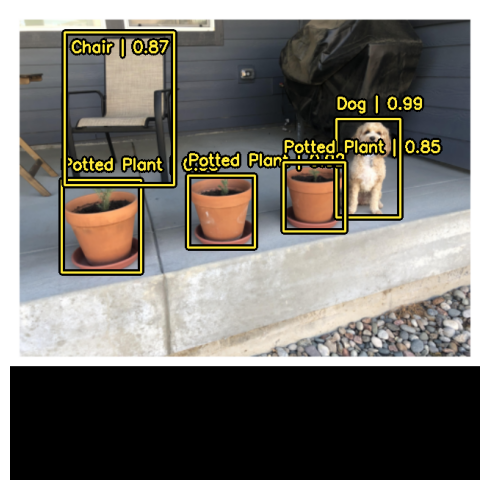

In [10]:
# в метод predict() передаем обработанный тензор изображения
# тензор изображения обрабатывается с помощью предобученной модели
# на выходе получаем предсказанный словарь тензоров
y_pred = pretrained_model.predict(image_batch)

# словарь y_pred содержит следующие тензоны:
# {"classes": ..., boxes": ..., confidence: ..., num_detections: ...} - подробное описание ниже в тексте
# визуализация объектных рамок на картинке
visualization.plot_bounding_box_gallery(
    image_batch, # обработанное изображение
    value_range=(0, 255), # диапазон значений пикселей
    rows=1, # количество строк в галерее на выходе
    cols=1, # количество столбцов в галерее на выходе
    y_pred=y_pred, # указатель на тензор с предсказанными данными, на основе него строим рамки на выходном рисунке
    scale=5, # масштаб изображения
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами объектов, для обозначения их на выходном рисунке
)

> Переменная y_pred - это словарь, в котором каждый элемент содержит тензоры, т.е. массивы с параметрами.  
В нашем случае, словарь содержит следующие тензоры:  
**boxes**: содержит 5 массивов с параметрами конкретной объектной рамки, каждый массив имеет 4 значения - x, y, w(idth), h(ight)  
**confidence**: уровень уверенности, в том что конкретная рамка является тем, чем ее распознали (относительный параметр)  
**classes**: индексы (номера) распознанных классов объектов  
**num_detections**: количество найденных классов

---

Для поддержания простоты во входном потоке, KerasCV применяет метод подавления немаксимумов (NMS) в классе `YOLOV8Detector`. Метод подавления немаксимумов - традиционный компьютерный алгоритм, который решает задачу обнаружения моделью множества рамок для одного и того же объекта.

Подавление немаксимумов хорошо настраиваемый алгоритм, вам в большинстве случаев нужно будет лишь указать аргументы для метода немаксимумов. Это можно сделать с помощью переопределения аргумента `prediction_decoder`.

Для демонстрации такой концепции, давайте временно отключим подавление немаксимумов в нашей модели YOLOV8Detector.
Это можно сделать, дописав атрибут `prediction_decoder`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


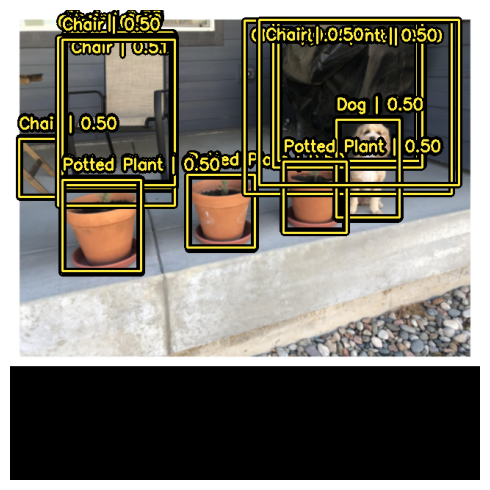

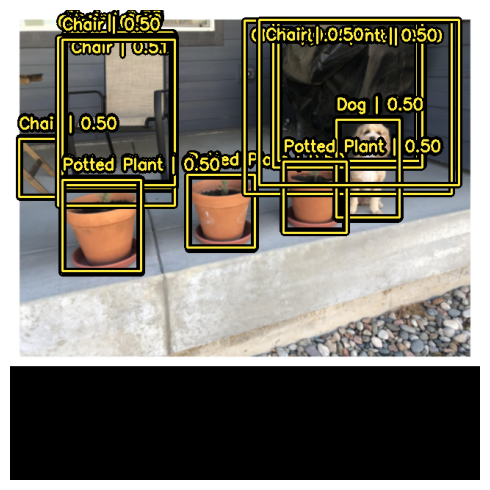

In [11]:
# Метод NonMaxSuppression слой предназначен для регулирования подавления немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат рамок
    from_logits=True, # отключаем использование в этом слое функций активации
    iou_threshold=1.0, # значение данного порога равное единице, означает полно отключение подавление немаксимумов
    confidence_threshold=0.0, # порог уровня уверенности равную нулю, позволяет отобразить все предполагаемые объектные рамки
)

# предобученная модель YOLO
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # конкретный тип модели YOLO, обученной на наборе данных Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # указатель на слой декодера без подавления немаксимумов
)

# получаем тензор от предобученной модели
y_pred = pretrained_model.predict(image_batch)

# визуализируем картинки с объектными рамками
visualization.plot_bounding_box_gallery(
    image_batch, # обработанная картинка
    value_range=(0, 255), # диапазон значений пикселей
    rows=1, # кол-во строк в галерее
    cols=1, # кол-во столбцов в галерее
    y_pred=y_pred, # указатель на тензор с предсказанными значениями
    scale=5, # масштаб
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами
)

Далее, давайте перенастроим `keras_cv.layers.NonMaxSuppression` для нашего примера! Мы настроим параметр `iou_threshold` на `0.2` и параметр `confidence_threshold` на `0.7`.

Увеличение значение параметра `confidence_threshold`, влияет на модель так, что на выходе будут объектные рамки с более высоким уровнем доверия.  
`iou_threshold` контролирует порог "пересечения над слиянием" (IoU), который будет таким, чтобы из двух рамок осталась только одна.

[Более подробное описание данного параметра смотрите в документации TensorFlow API docs](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


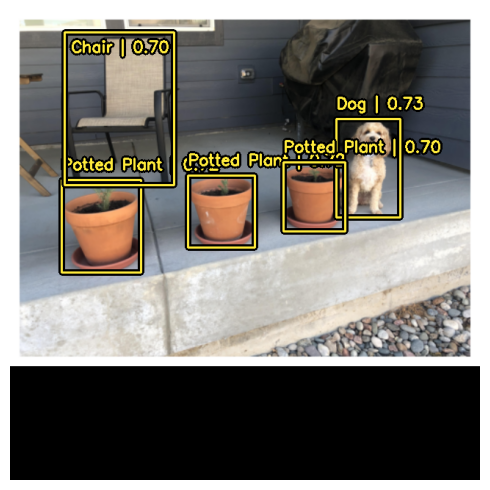

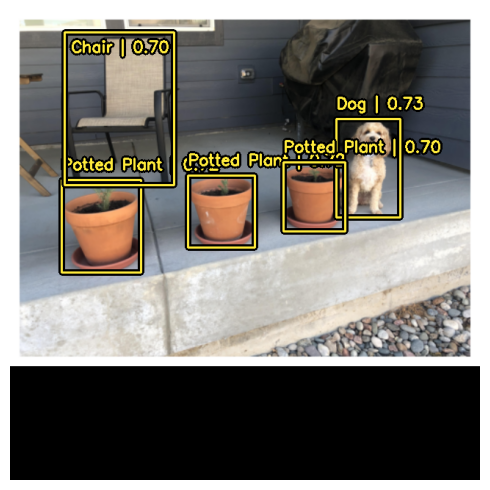

In [12]:
# слой NonMaxSuppression, позволяет контролировать подавление немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат объектных рамок
    from_logits=True, # применение логитов, позволяет обойтись без функции активации в данном слое.
    iou_threshold=0.2, # уменьшая порог IOU, отсекаем плохо распознаные объекты
    confidence_threshold=0.7, # настройка порога уверенности позволяет контролировать подавление немаксимумов
)

# получаем настройки предобученной модели YOLO
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # модель YOLO, предобученная на картинках из набора Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # тип декодера, в нашем случае, он определен выше - подавление немаксимумов
)

# получаем тензоры предсказаний
y_pred = pretrained_model.predict(image_batch)

# визуализации объектных рамок
visualization.plot_bounding_box_gallery(
    image_batch, # указатель на обработанную картинку
    value_range=(0, 255), # диапазон пикселей картинки
    rows=1, # кол-во строк
    cols=1, # кол-во столбцов
    y_pred=y_pred, # указатель на тензор с предсказанными параметрами
    scale=5, # масштаб картинки
    font_scale=0.7, # размер шрифтов
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами объектов
)

Так гораздо лучше!

## Обучение нестандартных моделей

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

Не важно, любитель ли вы в области обнаружения объектов, либо уже ветеран, сборка конвейера по обнаружению объектов с нуля, будет являться сложным делом, в любом случае. К счастью, все интерфейсы по обнаружению объектов в KerasCV построены по модульному принципу. Не важно, нужен ли вам готовый контейнер, либо просто модель по обнаружению, либо просто механизм преобразования формата из `xywh` в формат `xyxy`, KerasCV все это осилит.

В данном руководстве, мы собираем полностью обучаемый конвейер для модели обнаружения объектов на основе KerasCV. Включая загрузку данных, аугментацию, расчет метрик и вывод!

Для начала, давайте разберемся со всеми входными данными и зададим глобальные параметры.

In [13]:
BATCH_SIZE = 4

## Загрузка данных

Давайте определим форматы для загрузки и объектных рамок. KerasCV имеет предопределенный формат для рамок. Чтобы все это скомпоновать вместе, необходимо упаковать параметры рамок в словарь, как описано ниже:

```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

`bounding_boxes['boxes']` содержит координаты рамок в формате `bounding_box_format` поддерживаемым KerasCV.

KerasCV требует, чтобы аргумент `bounding_box_format` содержал все параметры, относящиеся к объектным рамкам. Это сделано для увеличения ваших возможностей по включению индивидуальных параметров в конвейер, также, позволяя коду быть самодокументированным на протяжении всего конвейера.

Что бы соответствовать стилю API KerasCV, рекомендуется задать загрузчик данных, используя аргумент `bounding_box_format`. Тогда тем, кто будет использовать ваш загрузчик данных, будет понятно, какой формат используется.  
В этом примере, мы задаем формат для рамок вида `xywh`.

Пример:

```python
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
```

Это задаст точный формат для рамок вида `xywh`. Об этом подробнее можно почитать в документации KerasCV в разделе формат рамок [в документации по API](https://keras.io/api/keras_cv/bounding_box/formats/).

Наши данные загружаются в формате `{"images": images, "bounding_boxes": bounding_boxes}`. Данный формат поддерживается всеми предварительными компонентами KerasCV.

Давайте загрузим данные и проверим, что данные выглядят как ожидается.

In [17]:
# функция визуализации данных
# на вход поступают аргументы: датасет, диапазон пикселей, кол-во строк, кол-во колонок, формат рамок
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1))) # создание итерируемого объекта из словаря тензоров картинки
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"] # призвоения соответсвующим переменным тензоров из словаря данных
    visualization.plot_bounding_box_gallery( # функция прорисовки картинок
        images, # тензор изображения
        value_range=value_range, # диапазон пикселей
        rows=rows, # кол-во строк
        cols=cols, # кол-во колонок
        y_true=bounding_boxes, # тензор предсказаний
        scale=5, # масштаб
        font_scale=0.7, # размер шрифта
        bounding_box_format=bounding_box_format, # формат объектных рамок
        class_mapping=class_mapping, # словарь объектных классов
    )

In [18]:
# функция распаковки (преобразования) "сырых" (необработанных) данных
def unpackage_raw_tfds_inputs(inputs, bounding_box_format): # на входе элементы словаря, и формат данных
    image = inputs["image"] # значение словаря по ключ image присваиваем переменной image
    # переменной рамок boxes присваивается конвертированное значения в соответствии с переданным форматом
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image, # текущая картинка переданная из функции load_pascal_voc
        source="rel_yxyx", # исходный относительный формат
        target=bounding_box_format, # конечный заданный формат
    )
    bounding_boxes = { # словарь формата объектных рамок
        "classes": inputs["objects"]["label"], # классы
        "boxes": boxes, # рамки
    }
    # возвращает словарь содержащий картинки и их форматы
    return {"images": image, "bounding_boxes": bounding_boxes}

In [19]:
# функция загрузки данных
def load_pascal_voc(split, dataset, bounding_box_format):
    # процедура загрузки сырых данных, с разбиением на части с тусованием
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    # структуризация данных по заданному формату с помощью параметра bounding_box_format
    ds = ds.map(
        # каждый элемент набора данных обрабатывается функцией unpackage_raw_tfds_inputs, возвращающей словарь
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        # настройка производительности - параллельные вычисления
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds # возвращаем датасет

In [20]:
# Загружаем тренировочные данные
train_ds = load_pascal_voc(split="train", # параметр, указывающий какую часть данных загрузить: train, test или validation
                           dataset="voc/2007", # указываем тип и версия набора данных
                           bounding_box_format="xywh") # формат объектных рамок

# Загружаем тестовые данные
eval_ds = load_pascal_voc(split="test",
                          dataset="voc/2007",
                          bounding_box_format="xywh")

# перемешиваем тренировочные данные блоками, в блоке 16 единиц данных
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

PermissionError: [WinError 5] Отказано в доступе: 'C:\\Users\\shive\\tensorflow_datasets\\downloads\\extracted\\TAR.pjreddi.com_media_files_VOCtest_6-Nov-2007aDaIji4B3KhFd6hJ0zn6T3Ph5PE10xJDDEhWtWCbSJI.tar.incomplete_2aef519f05ae461192db425c65cd56c1' -> 'C:\\Users\\shive\\tensorflow_datasets\\downloads\\extracted\\TAR.pjreddi.com_media_files_VOCtest_6-Nov-2007aDaIji4B3KhFd6hJ0zn6T3Ph5PE10xJDDEhWtWCbSJI.tar'

Next, let's batch our data.

In KerasCV object detection tasks it is recommended that
users use ragged batches of inputs.
This is due to the fact that images may be of different sizes in PascalVOC,
as well as the fact that there may be different numbers of bounding boxes per
image.

To construct a ragged dataset in a `tf.data` pipeline, you can use the
`ragged_batch()` method.

In [13]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Let's make sure our dataset is following the format KerasCV expects.
By using the `visualize_dataset()` function, you can visually verify
that your data is in the format that KerasCV expects.  If the bounding boxes
are not visible or are visible in the wrong locations that is a sign that your
data is mis-formatted.

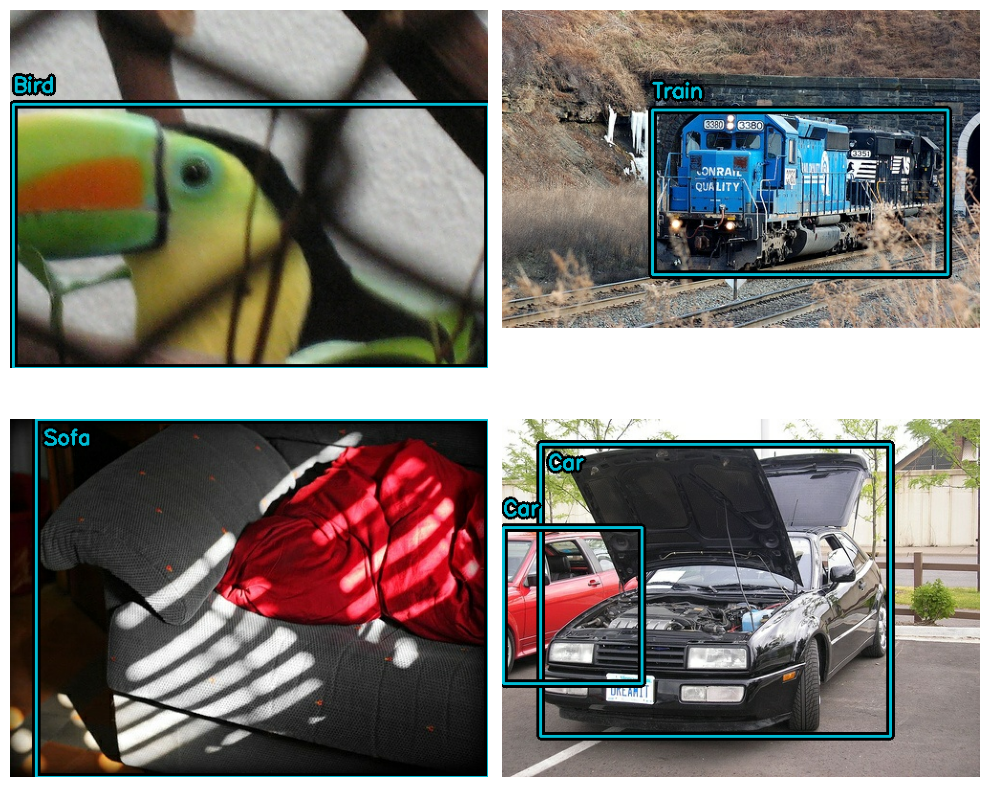

In [14]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

And for the eval set:

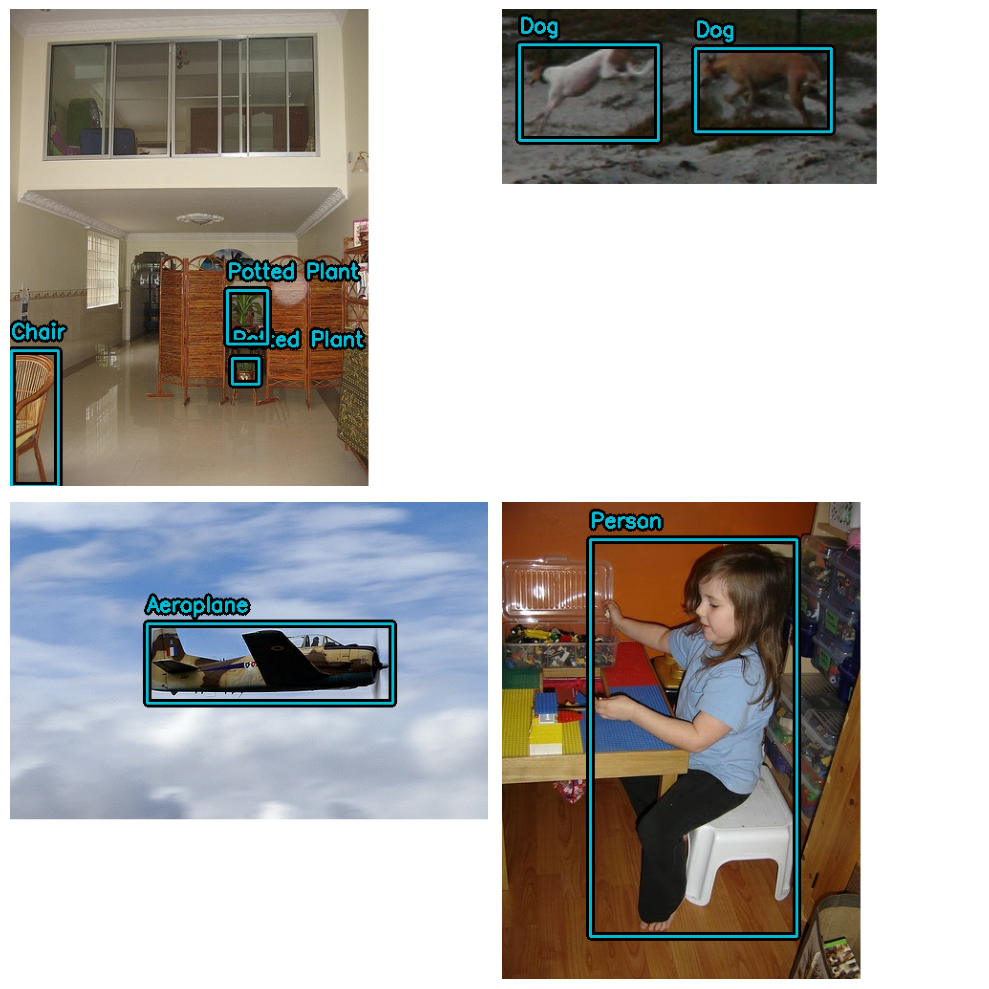

In [15]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

Looks like everything is structured as expected.
Now we can move on to constructing our
data augmentation pipeline.

## Data augmentation

One of the most challenging tasks when constructing object detection
pipelines is data augmentation.  Image augmentation techniques must be aware of the underlying
bounding boxes, and must update them accordingly.

Luckily, KerasCV natively supports bounding box augmentation with its extensive
library
of [data augmentation layers](https://keras.io/api/keras_cv/layers/preprocessing/).
The code below loads the Pascal VOC dataset, and performs on-the-fly,
bounding-box-friendly data augmentation inside a `tf.data` pipeline.

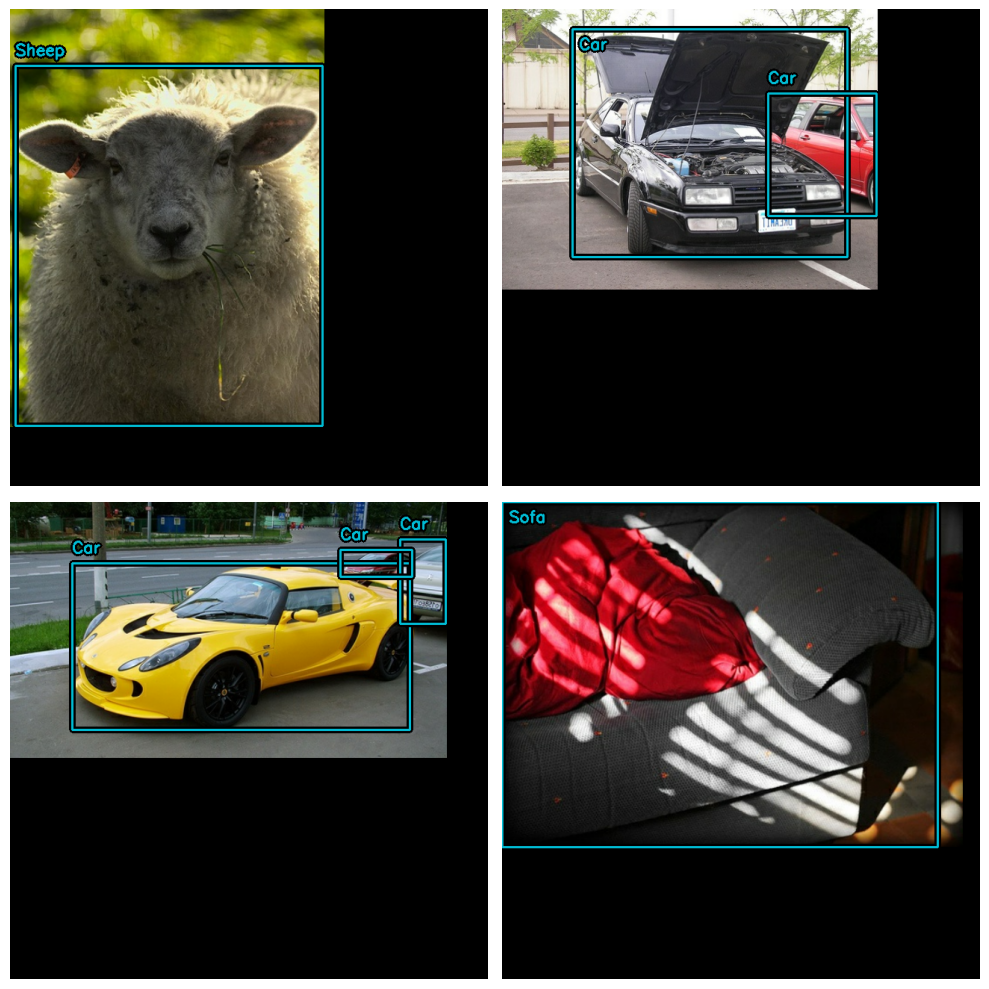

In [16]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Great! We now have a bounding-box-friendly data augmentation pipeline.
Let's format our evaluation dataset to match.  Instead of using
`JitteredResize`, let's use the deterministic `keras_cv.layers.Resizing()`
layer.

In [17]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

Due to the fact that the resize operation differs between the train dataset,
which uses `JitteredResize()` to resize images, and the inference dataset, which
uses `layers.Resizing(pad_to_aspect_ratio=True)`, it is good practice to
visualize both datasets:

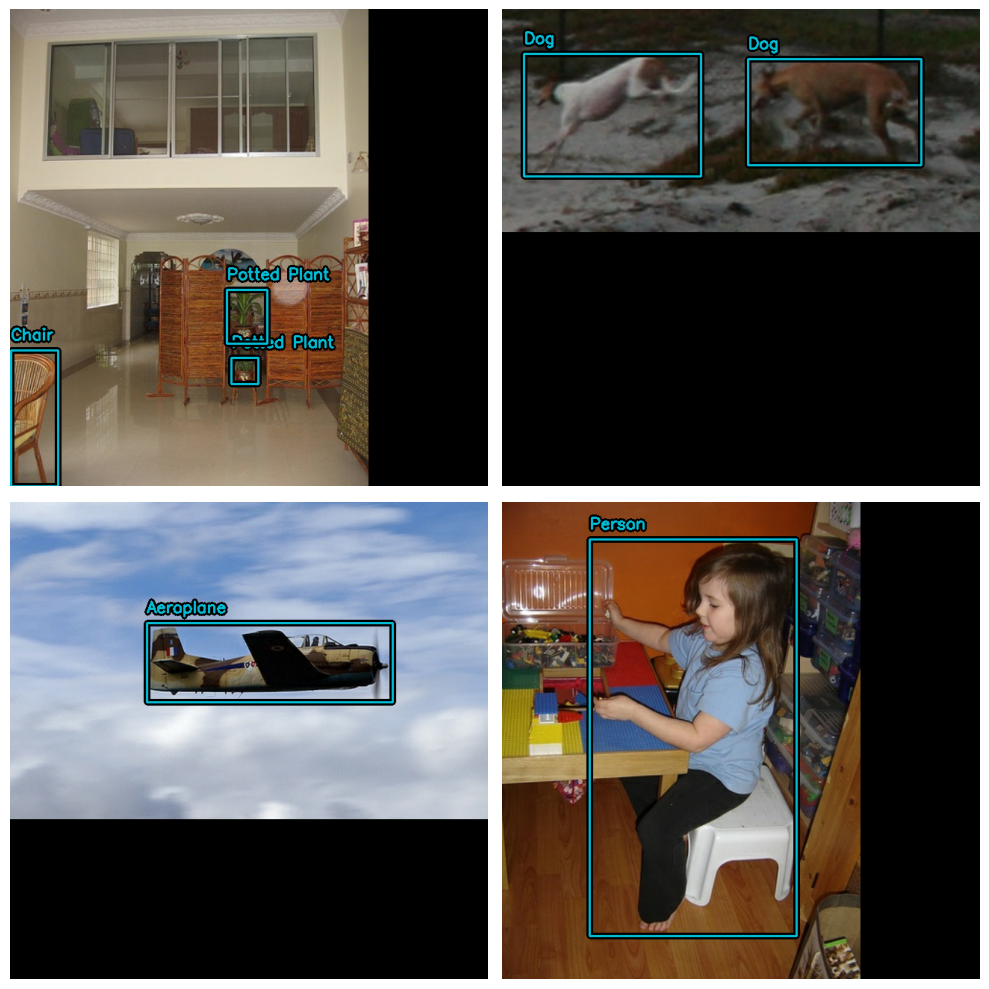

In [18]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Finally, let's unpackage our inputs from the preprocessing dictionary, and
prepare to feed the inputs into our model.  In order to be TPU compatible,
bounding box Tensors need to be `Dense` instead of `Ragged`.

In [19]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)